### 遷移學習 (從CNN偷訓練過的模型來繼續訓練)
> 1.固定 CNN(特徵抓取) 2.訓練MLP(辨認) 3.重新訓練整個 fine-tune

### Inception -> 視野變寬
> 大的視野找大東西, 小的視野找小東西

> ex: (32,32,3) 圖, 

> filter 
> 3*3(中); 
> 1*1(中); 
> 3*3連做二次=5*5(大)

> 之後把 convolution 結果疊在一起

### ResNet(殘差網路)->視野變深,但是要解決梯度消失
> 衡等映射(啥進入就啥出來) -> 神經元輸出 weight 手動設定 output 對應一個 神經元輸入(1) 其他(0)

> 梯度消失

> 連鎖法則: -rho_Loss/rho_a1 = 經過路徑為斜率直接相乘;

> input -> L(input) -> output

> 如果結果比恆等映射還爛就做: input -> input +　L(input) -> output

> input +　L(input) -> 梯度主要調整 L(input), 即差值(output-input)

> 感覺很像堆積木己經堆得差不多, 再做調整

#### 卷積步長
> ex: 步長2卷積, 即 filter 卷積窗一次移動2步(原本是1步,類似做pooling) -> output 的寬高縮小

> 缺點是有些格子只看一次, 有些看了二次(重疊看的部位), 解決方法是把 kernal size改成4(被看的拉大(類似加padding))

> 可以整除的才是平均的(每格被看的次數差不多) ex:6*6,kernal size(即 filter 大小)2, 可以讓6被2整除






In [0]:
import zipfile

f = zipfile.ZipFile("drive/My Drive/train.zip") # 自動解壓縮
f.extractall("./datasets")

In [0]:
import glob
import pandas as pd
catfs = glob.glob("datasets/train/cat.*.jpg")
catans = [0]*len(catfs) # 貓 lable 0
dogfs = glob.glob("datasets/train/dog.*.jpg")
dogans = [1]*len(dogfs) # 狗 1
df = pd.DataFrame({
    "path": catfs + dogfs,
    "target": catans + dogans
})
df

,path,target
0,datasets/train/cat.11630.jpg,0
1,datasets/train/cat.3765.jpg,0
2,datasets/train/cat.591.jpg,0
3,datasets/train/cat.6686.jpg,0
4,datasets/train/cat.2384.jpg,0
...,...,...
24995,datasets/train/dog.9502.jpg,1
24996,datasets/train/dog.10694.jpg,1
24997,datasets/train/dog.7585.jpg,1
24998,datasets/train/dog.1878.jpg,1


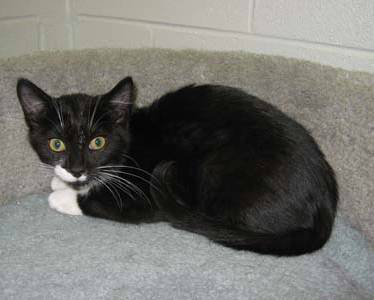

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 1
load_img(df["path"][idx])

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
# include_top=False 表示自己訓練MLP,不用原本訓練過的
cnn = VGG16(include_top=False, input_shape=(224,224,3))
cnn.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
# # sequentioal 式
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# model = Sequential()
# for l in cnn.layers:
#   l.trainable = False # 只訓練額外加入的, 其他用原本的
#   model.add(l)
# model.add(Flatten()) # 開始額外加入
# model.add(Dense(128, activation="relu"))
# model.add(Dense(2, activation="softmax")) # 預備使用2分類
# model.summary()

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = False
# 放在 flatten 後不對
x = BatchNormalization()(cnn.output) # !!!! 這邊加入 BatchNormalization
# x = Flatten()(cnn.output)
x = Flatten()(x)
# x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x) # !!!! 數據量小參數跟著調小
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# from tensorflow.keras import Model
# # def test():
# #   return int
# # test()(3.14) # 得到API 再繼續執行功能
# x = Flatten()(cnn.output)
# x = Dense(128, activation="relu")(x)
# out = Dense(2, activation="softmax")(x)
# model2 = Model(input=cnn.input, output=out) # Sequential 無法處理兩個同時 Input

# from tensorflow.keras.models import Model
# for l in cnn.layers:
#     # !!! trainable一定要先設置
#     l.trainable = False
# x = Flatten()(cnn.output)
# x = Dense(128, activation="relu")(x)
# out = Dense(2, activation="softmax")(x)
# model = Model(inputs=cnn.input, outputs=out)
# model.summary()

In [0]:
# from tensorflow.keras.layers import Input, Concatenate
# in1 = Input(shape=(224,224,3))
# in2 = Input(shape=(224,224,3))
# conv1 = cnn(in1)
# conv2 = cnn(in2)
# merge = Concatenate()([conv1,conv2]) # 連接二個不同的 tensor input
# x = Flatten()(merge)
# out = Dense(1, activation="sigmoid")(x)
# model = Model(input=[in1,in2], output=out)
# model.summary()

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss = SparseCategoricalCrossentropy(),
       optimizer= "adam",
       metrics=["accuracy"])

In [0]:
# 訓練以前, 把所有的 list, series... -> 轉成 nparray (不轉, 雖然值是空值, 但 index 還會存在)
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                             np.array(df["target"]),
                             test_size = 0.1)

In [0]:
# 請使用裡面的預處理, 不要自己來
from tensorflow.keras.applications.vgg16 import preprocess_input #　VGG16 是 caffee, 不需要額外做 normalize 轉 -1~1 送進 tf

# return: (原圖(batch), 處理後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
  idx = np.random.randint(0, x.shape[0], size=batch) # 先隨機取小部分
  x_batch, y_batch = x[idx], y[idx]
  x_ori, x_pre = [], []
  for fp in x_batch:
    img = load_img(fp, target_size=(224, 224)) # 圖片統一縮放
    img_np = np.array(img)
    # 原本的圖片我存一份(需要才讀取)
    x_ori.append(img_np)
    img_pre = preprocess_input(img_np)
    # 預處理的圖片
    x_pre.append(img_pre)
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  return (x_ori, x_pre, y_batch)

In [0]:
# train on batch
for i in range(20):
  print("-" * 10, i, "-" * 10)
  _, x, y = dataflow(x_train, y_train)
  result = model.train_on_batch(x, y) # train_on_batch like fit, return # loss, output 
  print("[Train]:", result)  
  # 如果有時間, validate 可以調高一點
  _, x, y = dataflow(x_test, y_test)
  result = model.test_on_batch(x, y)
  print("[Validate]:", result)
  # note: loss 數值震盪大(預測錯差很多) 一定有問題

---------- 0 ----------
[Train]: [0.9349368810653687, 0.550000011920929]
[Validate]: [6.473137855529785, 0.6499999761581421]
---------- 1 ----------
[Train]: [1.1878583431243896, 0.6499999761581421]
[Validate]: [1.879394769668579, 0.800000011920929]
---------- 2 ----------
[Train]: [0.5135059356689453, 0.800000011920929]
[Validate]: [0.6354317665100098, 0.8999999761581421]
---------- 3 ----------
[Train]: [2.759443759918213, 0.6499999761581421]
[Validate]: [0.3765023350715637, 0.949999988079071]
---------- 4 ----------
[Train]: [1.9538633823394775, 0.699999988079071]
[Validate]: [0.12504388391971588, 0.949999988079071]
---------- 5 ----------
[Train]: [0.39694029092788696, 0.8500000238418579]
[Validate]: [0.2553246021270752, 0.949999988079071]
---------- 6 ----------
[Train]: [0.16096718609333038, 0.949999988079071]
[Validate]: [2.518392562866211, 0.8999999761581421]
---------- 7 ----------
[Train]: [0.49934378266334534, 0.800000011920929]
[Validate]: [0.3675798773765564, 0.94999998807

In [0]:
model.predict(x) # 機率接近1->斜率是0, 一開始就被分錯, 之後就再也調不回來->落在0 or 1 (理想中, 於 sigmoid 不會有分布在接近 0 or 1 的點)
# note: 預測機率是 0 or 1 一定有問題, ex: CNN(caffee) 輸出大的參數給原本要 0~1的 MLP (tf) -> 需要做 Batch Normalization

# """
# 特別的 normalize: Batch Normalization(BN)
# ex: 7*7 的圖, 20 張, Xi->BN->Xi_new
# 1. 1st 分數圖取平均: 7*7*20: u1,sigma_1 let Xi = Xi-ui/sigma_i 使其高斯分布後(0~1, 標準差1)
# 2. 不要讓每個 batch 都沒有自己的平均跟標準差(沒特色), 使用原本未處理的平均(gama)跟標準差(beta), Xi*beta_i+gama_i 讓其還原
# 結論就是, 讓每個 batch 調整成 tf 能接受的 平均與標準差 (1.常態分佈 2.還原特色)

# beta、gama 是 讓每個 batch 自己決定:
# 一開始隨便給, 之後使用 loss 做調整: -rhoLoss/rhoBeta - -rhoLoss/rhoGama
# """

array([[2.1904136e-18, 1.0000000e+00],
       [1.0000000e+00, 1.8462342e-22],
       [1.0000000e+00, 3.1049903e-23],
       [8.4142425e-28, 1.0000000e+00],
       [1.2257005e-18, 1.0000000e+00],
       [1.0000000e+00, 7.8387487e-28],
       [1.0000000e+00, 3.7553580e-10],
       [9.9708098e-01, 2.9190206e-03],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.9659121e-08],
       [0.0000000e+00, 1.0000000e+00],
       [1.0462416e-37, 1.0000000e+00],
       [3.8465968e-34, 1.0000000e+00],
       [5.2265432e-25, 1.0000000e+00],
       [1.0000000e+00, 3.9698838e-18],
       [2.6552818e-23, 1.0000000e+00],
       [1.0000000e+00, 3.7900892e-23],
       [1.0000000e+00, 1.0814811e-14],
       [3.3530618e-36, 1.0000000e+00],
       [9.9979752e-01, 2.0252859e-04]], dtype=float32)

In [0]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx,ty)

16/16 [==============================] - 4s 225ms/step - loss: 0.5572 - accuracy: 0.9460


[0.5571784377098083, 0.9459999799728394]

In [0]:
# predict_classes: Model 沒有
# predict + argmax = predict_classes
# argmin: 幫你找到最大值的 index(axis=-1 == axis=1)
pre = model.predict(tx).argmax(axis=1) # 橫軸找大
pre

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,

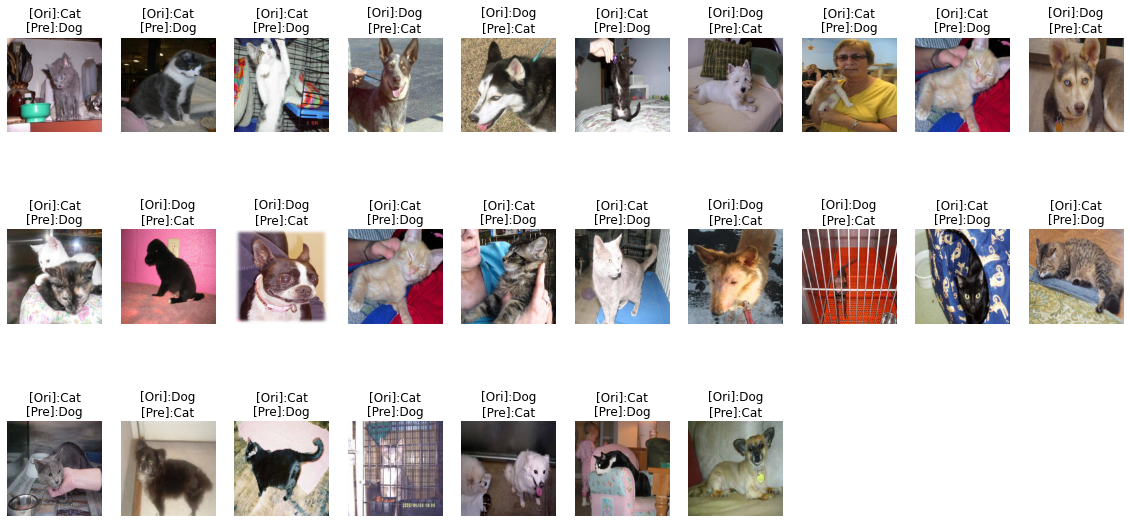

In [0]:
# (x座標, y座標, z座標)
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)